In [2]:
# data processing
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf

## Load the data

In [3]:
data_path = "DATA/VENUS_EXPRESS/"

vex_df = pd.read_csv(data_path+"VEX_NDMW0D0A_2023_01_11_12_55_55.900.txt", sep='\t')

## Venus Express data

In [4]:
#vex_df['DATE_TIME'] = vex_df.DATE_TIME.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f')) #takes more time for the graphs to show
vex_df.set_index('DATE_TIME', inplace=True)
display(vex_df.head())

,NDMW0D0A
DATE_TIME,
2005-11-09 00:09:04.575,0
2005-11-09 00:10:08.575,0
2005-11-09 00:11:12.576,0
2005-11-09 00:12:16.576,0
2005-11-09 00:13:20.577,0


In [5]:
vex_df.iloc[0]

NDMW0D0A    0
Name: 2005-11-09 00:09:04.575, dtype: int64

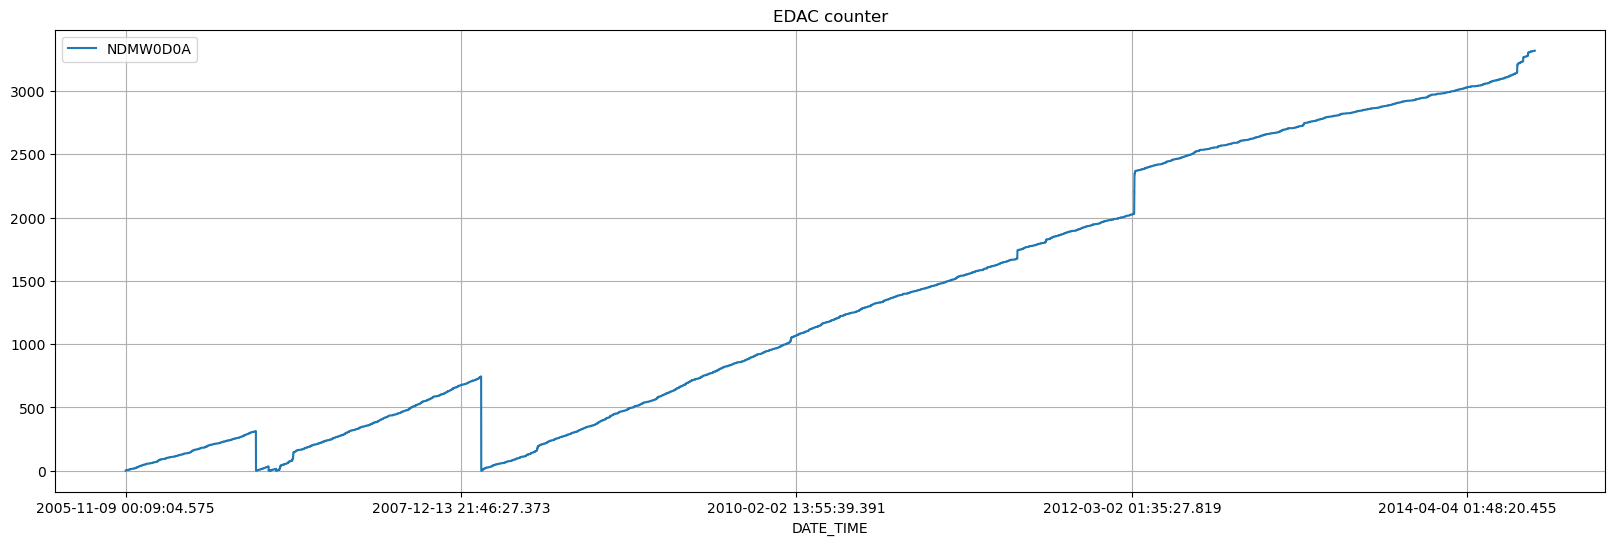

In [6]:
vex_df.plot(kind='line', figsize=(20,6))
plt.title('EDAC counter')
plt.grid()
plt.show()

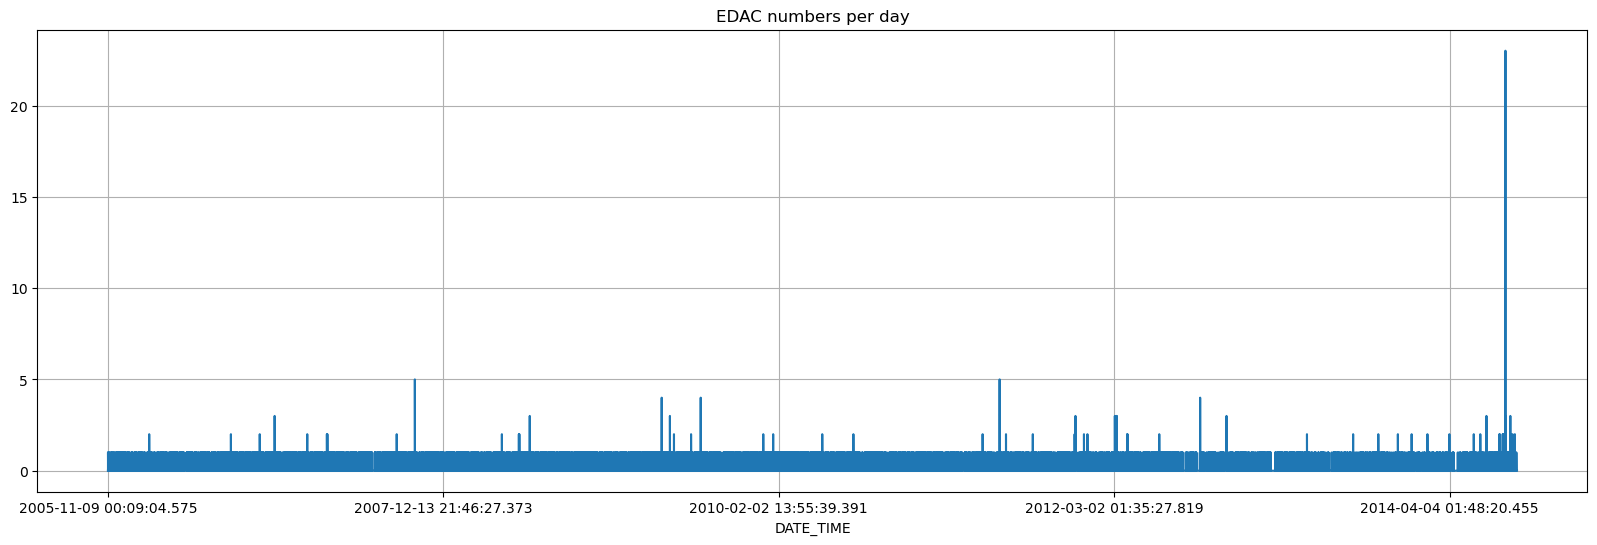

In [7]:
# calcumate the counts per day and remove the resetting of the counter at 0
vex_df['EDAC'] = vex_df['NDMW0D0A'].diff().bfill().astype(int).map(lambda x: max(0, x))

vex_df['EDAC'].plot(kind='line', figsize=(20,6))
plt.title('EDAC numbers per day')
plt.grid()
plt.show()

Now let's visualize on top of this plot the events of CME :

In [8]:
vex_cme_df = pd.read_csv(data_path+"VEX_CME_date_time.csv")

In [9]:
vex_df['cme'] = 0

for index, row in vex_cme_df.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Set 'cme' column values to 1 between start_time and end_time
    vex_df.loc[(vex_df.index >= start_time) & (vex_df.index <= end_time), 'cme'] = 1

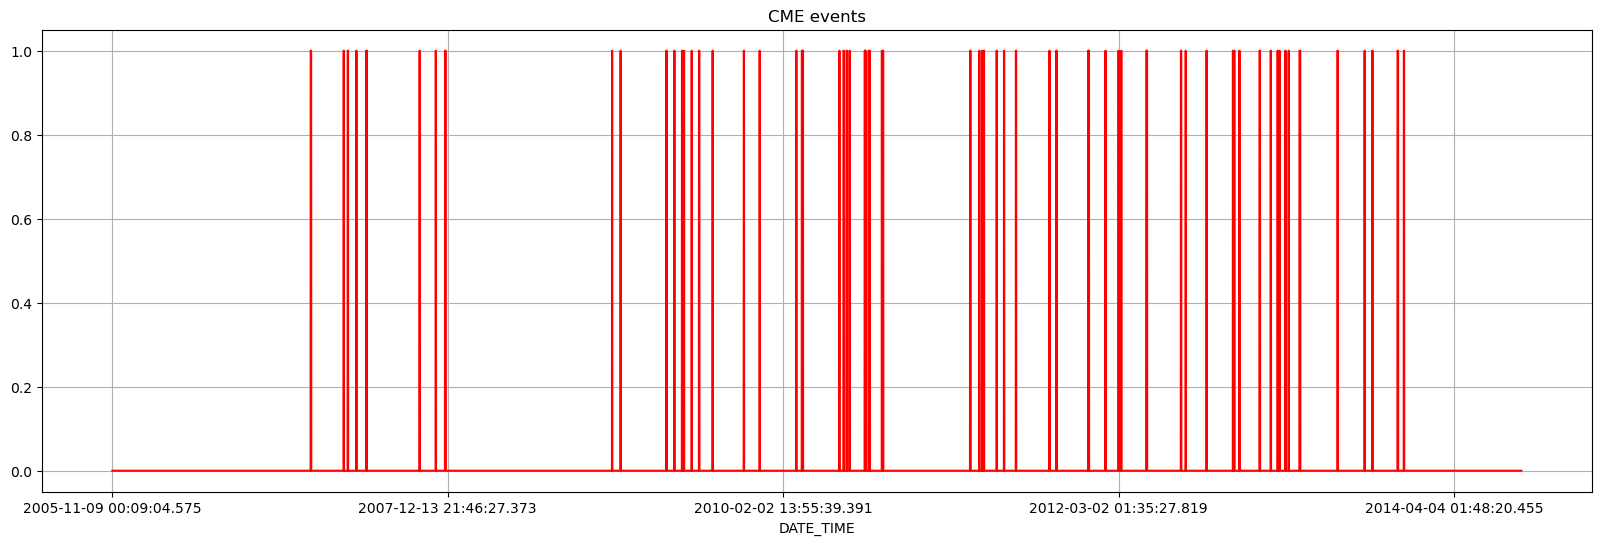

In [10]:
vex_df['cme'].plot(kind='line', figsize=(20,6), color='red')
plt.title('CME events')
plt.grid()
plt.show()

### Looking at EDAC and CME events

In [23]:
vex_df = vex_df[vex_df['EDAC'] <= 5]
vex_df.index = pd.to_datetime(vex_df.index)

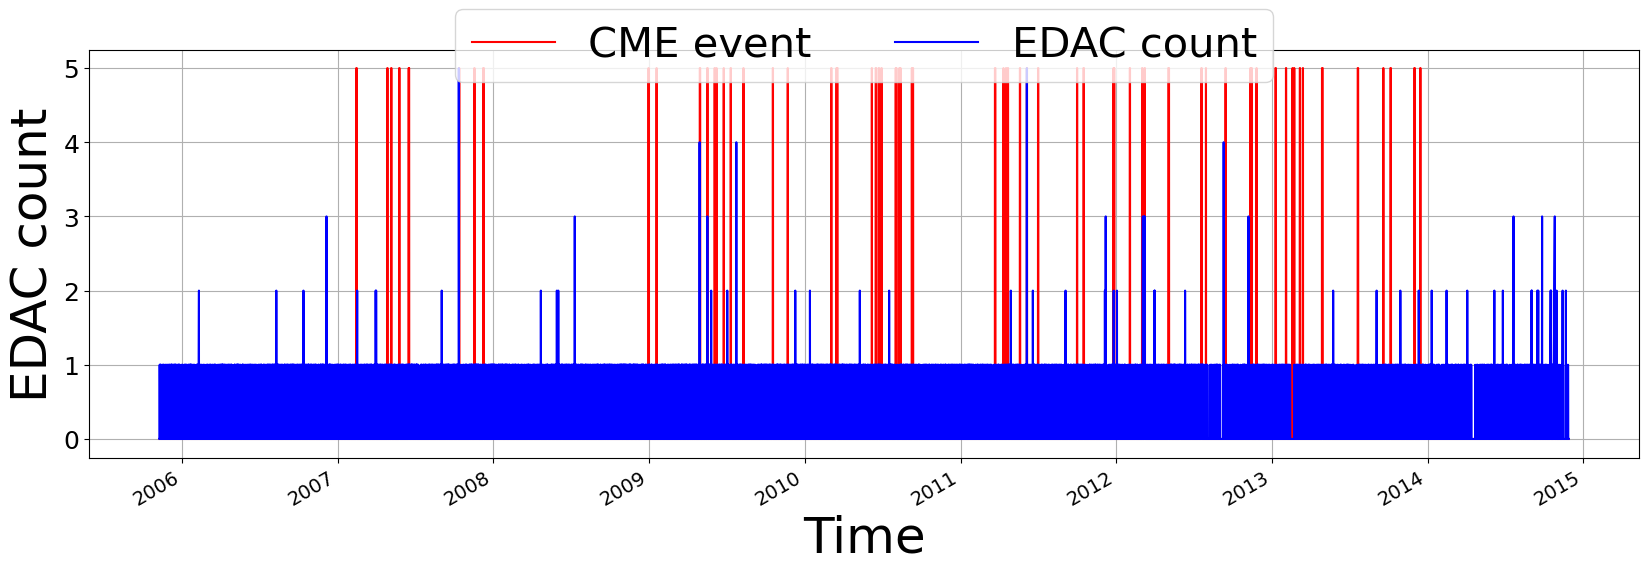

In [24]:
# make text bigger for the report
plt.rcParams.update({
    'font.size': 24,
    'axes.labelsize': 36,
    'axes.titlesize': 22,
    'xtick.labelsize': 14,
    'ytick.labelsize': 18, 
    'legend.fontsize': 30,
    'figure.titlesize': 24
})

fig, ax = plt.subplots(figsize=(20, 6))

# Plot 'cme'
(vex_df['cme']*5).plot(kind='line', color='red', label='CME event')

# Plot 'EDAC' on top of 'cme'
vex_df['EDAC'].plot(kind='line', color='blue', label='EDAC count')

ax.set_xlabel('Time')
ax.set_ylabel('EDAC count')

plt.title('')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

We can also look at the EDAC counter (sum) :

/tmp/ipykernel_418716/1626825029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vex_df['EDAC_counter'] = vex_df['EDAC'].cumsum()


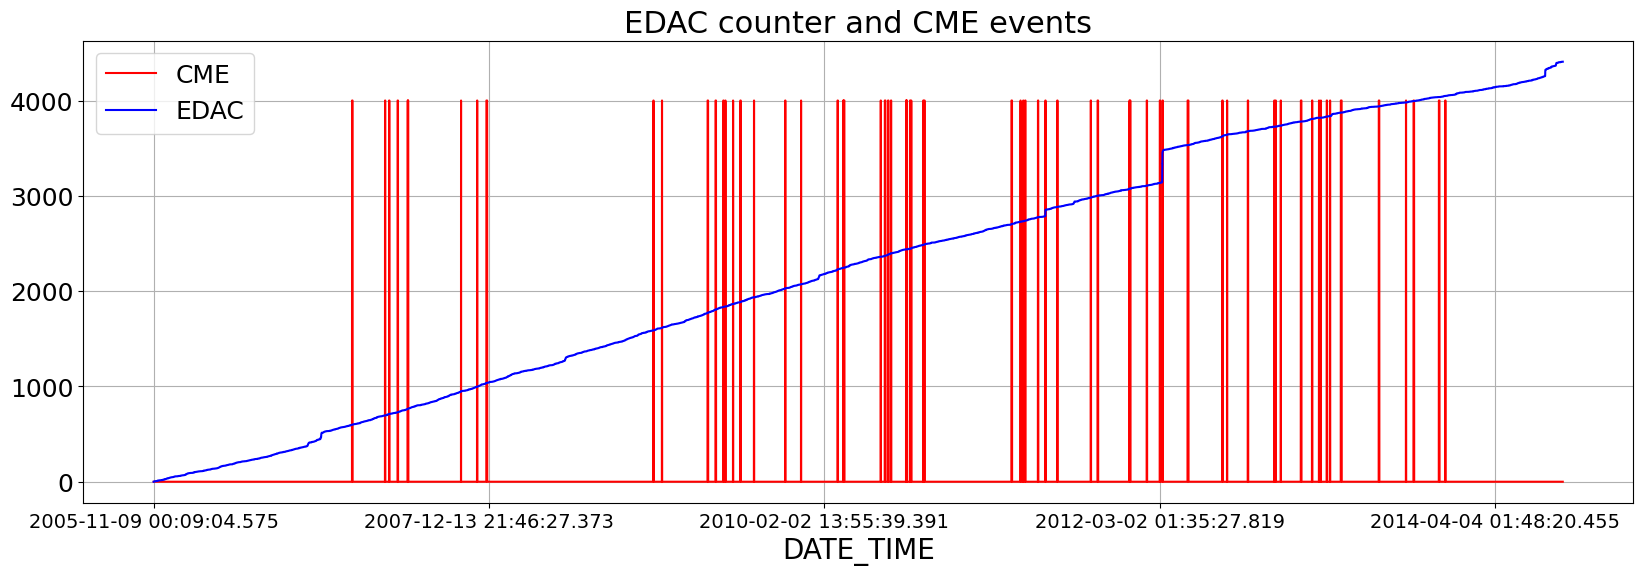

In [13]:
# edac counter without the restting of the counter at 0
vex_df['EDAC_counter'] = vex_df['EDAC'].cumsum()

fig, ax = plt.subplots(figsize=(20, 6))
(vex_df['cme']*4000).plot(kind='line', color='red', label='CME')
vex_df['EDAC_counter'].plot(kind='line',color='blue', label='EDAC')

plt.title('EDAC counter and CME events')
plt.grid()
plt.legend()
plt.show()

# MARS EXPRESS

In [ ]:
data_path = "DATA/MARS_EXPRESS/"

mex_df = pd.read_csv(data_path+"MeX_daily_edac.txt", sep='\t')
mex_df.columns = ['DATE_TIME', 'EDAC_COUNTER']
mex_df.set_index('DATE_TIME', inplace=True)
mex_df.index = pd.to_datetime(mex_df.index)

mex_df.plot(kind='line', figsize=(20,6))
plt.title('EDAC counter')
plt.grid()
plt.show()

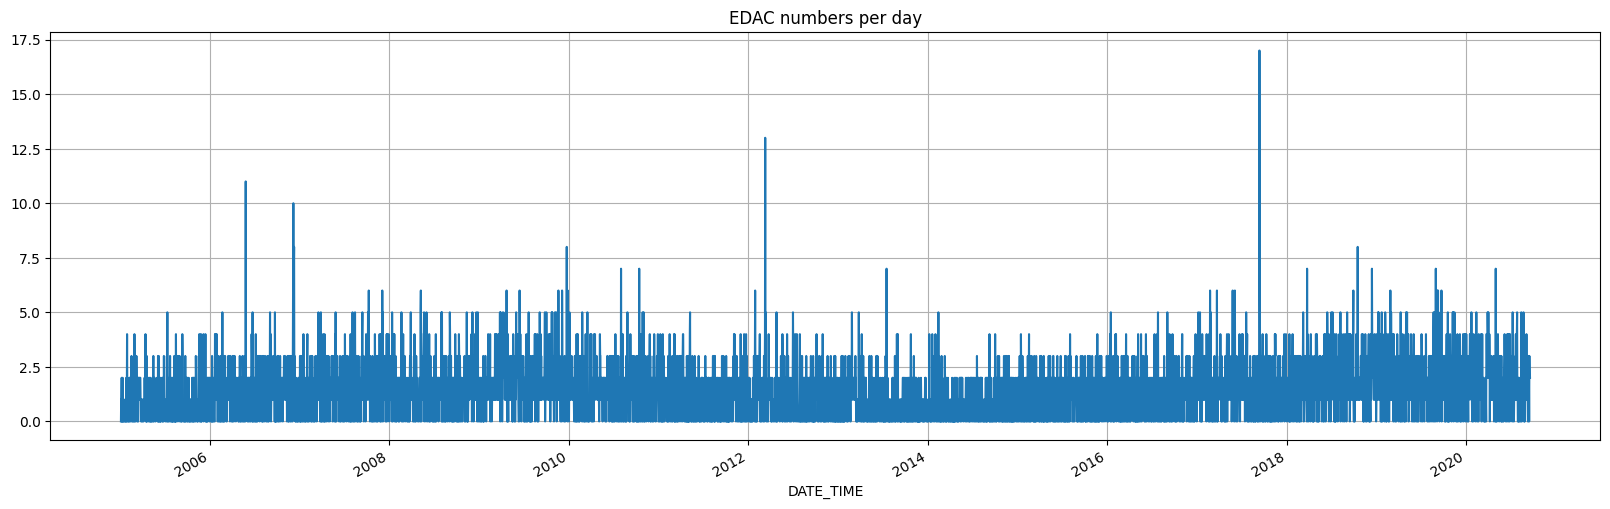

In [ ]:
# calcumate the counts per day and remove the resetting of the counter at 0
mex_df['EDAC'] = mex_df['EDAC_COUNTER'].diff() #.bfill().astype(int).map(lambda x: max(0, x))

mex_df['EDAC'].plot(kind='line', figsize=(20,6))
plt.title('EDAC numbers per day')
plt.grid()
plt.show()

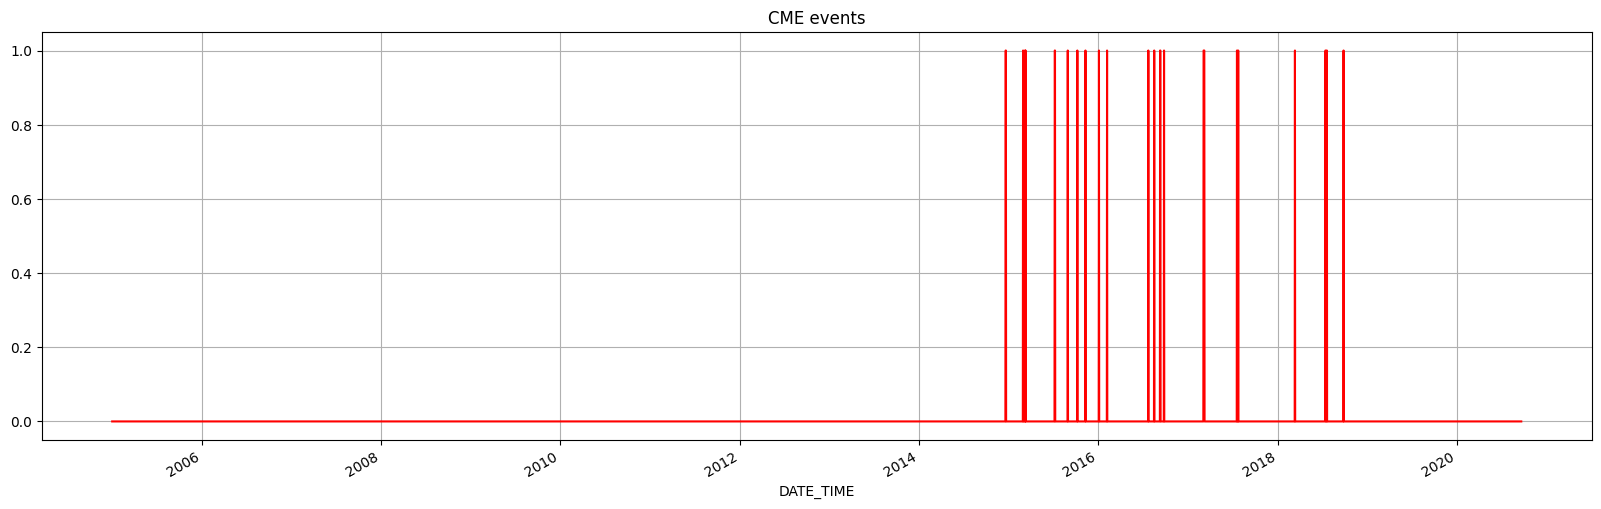

In [ ]:
mex_cme_df = pd.read_csv(data_path+"MEX_CME_date_time.csv")

mex_df['cme'] = 0

for index, row in mex_cme_df.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Set 'cme' column values to 1 between start_time and end_time
    mex_df.loc[(mex_df.index >= start_time) & (mex_df.index <= end_time), 'cme'] = 1

mex_df['cme'].plot(kind='line', figsize=(20,6), color='red')
plt.title('CME events')
plt.grid()
plt.show()

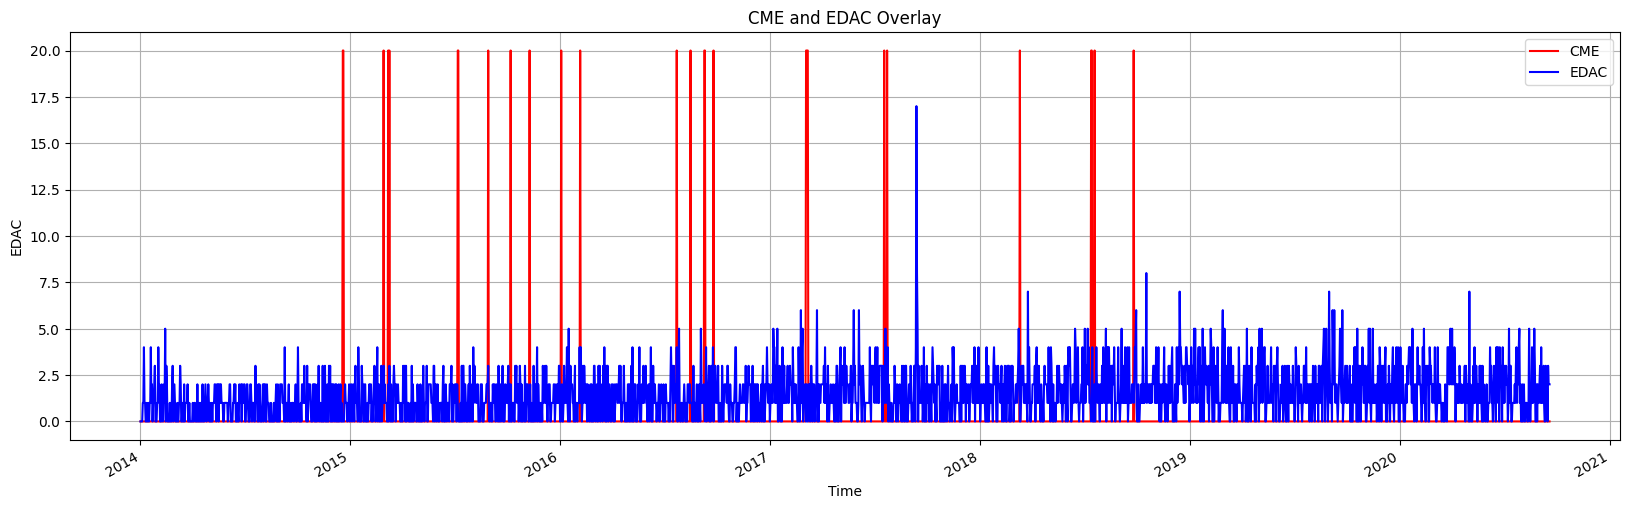

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))

# Plot 'cme'
(mex_df.loc['2014':]['cme']*20).plot(kind='line', color='red', label='CME')

# Plot 'EDAC' on top of 'cme'
mex_df.loc['2014':]['EDAC'].plot(kind='line', color='blue', label='EDAC')

ax.set_xlabel('Time')
ax.set_ylabel('EDAC')

plt.title('CME and EDAC Overlay')
plt.grid()
plt.legend()
plt.show()

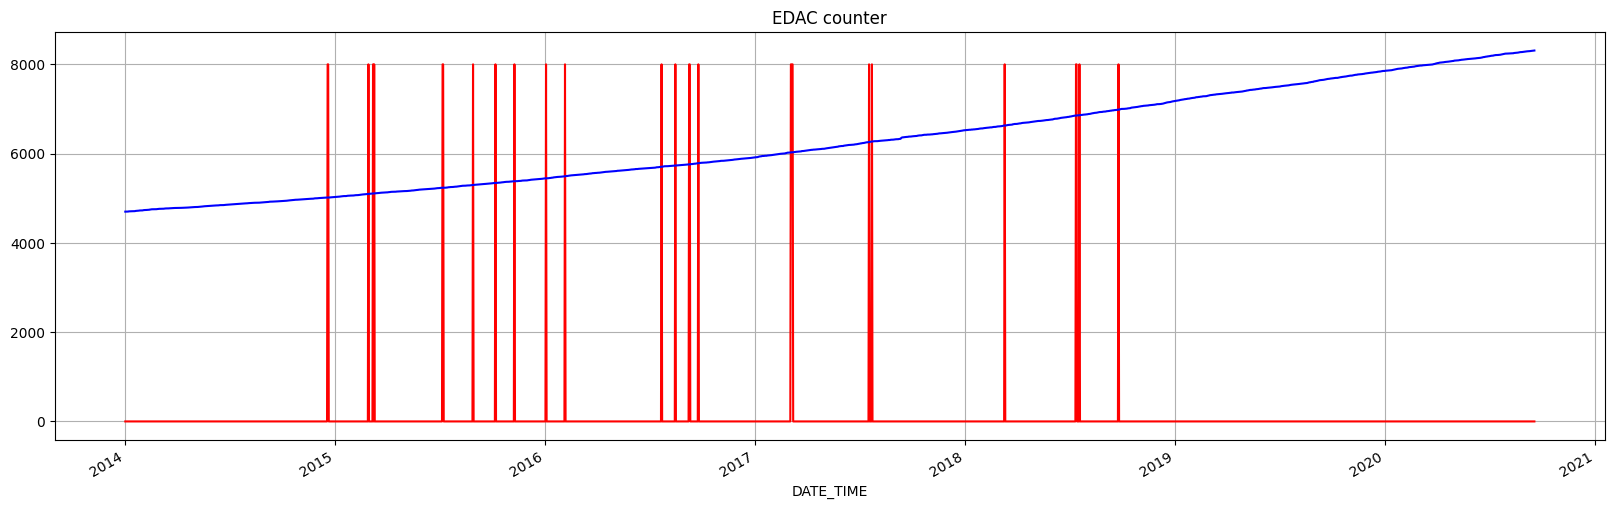

In [ ]:
#mex_df.loc['2014':].plot(kind='line', figsize=(20,6))

(mex_df.loc['2014':]['cme']*8000).plot(kind='line', color='red', label='CME', figsize=(20,6))

# Plot 'cme'
#(mex_df.loc['2014':]['cme']*20).plot(kind='line', color='red', label='CME')

# Plot 'EDAC' on top of 'cme'
mex_df.loc['2014':]['EDAC_COUNTER'].plot(kind='line', color='blue', label='EDAC')

plt.title('EDAC counter')
plt.grid()
plt.show()

# ROSETTA

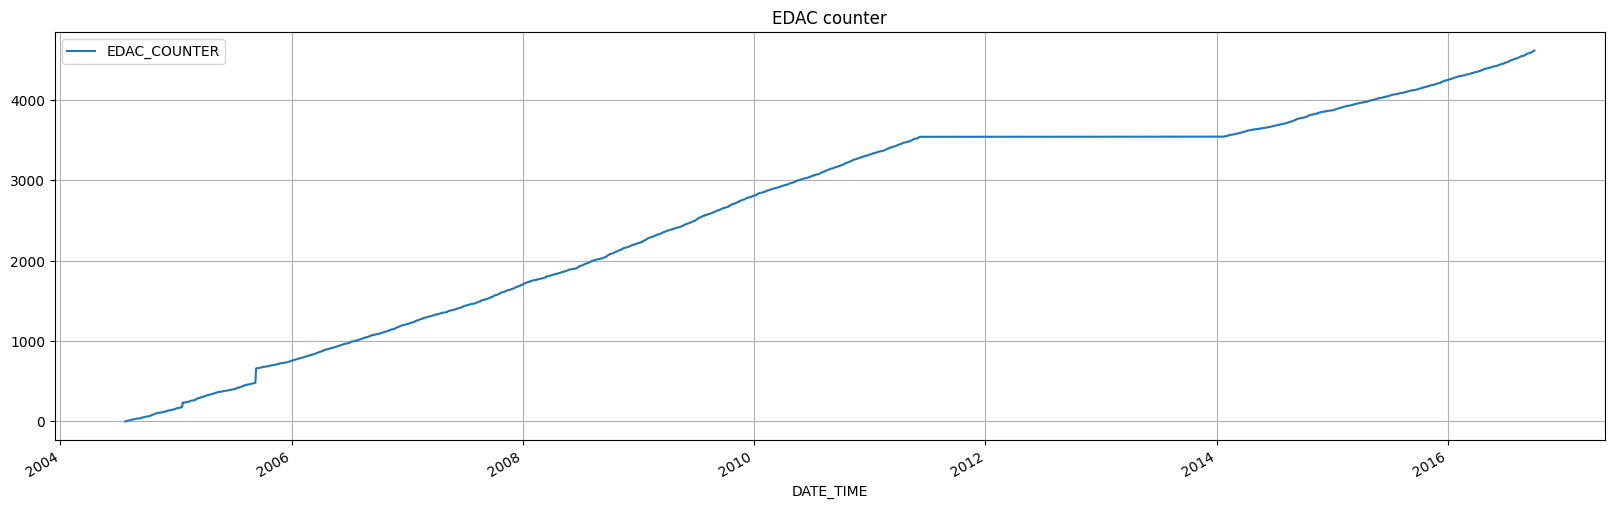

In [ ]:
data_path = "DATA/ROSETTA/"

ros_df = pd.read_csv(data_path+"Nac_daily_edac.txt", sep='\t')
ros_df.columns = ['DATE_TIME', 'EDAC_COUNTER']
ros_df.set_index('DATE_TIME', inplace=True)
ros_df.index = pd.to_datetime(ros_df.index)

ros_df.plot(kind='line', figsize=(20,6))
plt.title('EDAC counter')
plt.grid()
plt.show()

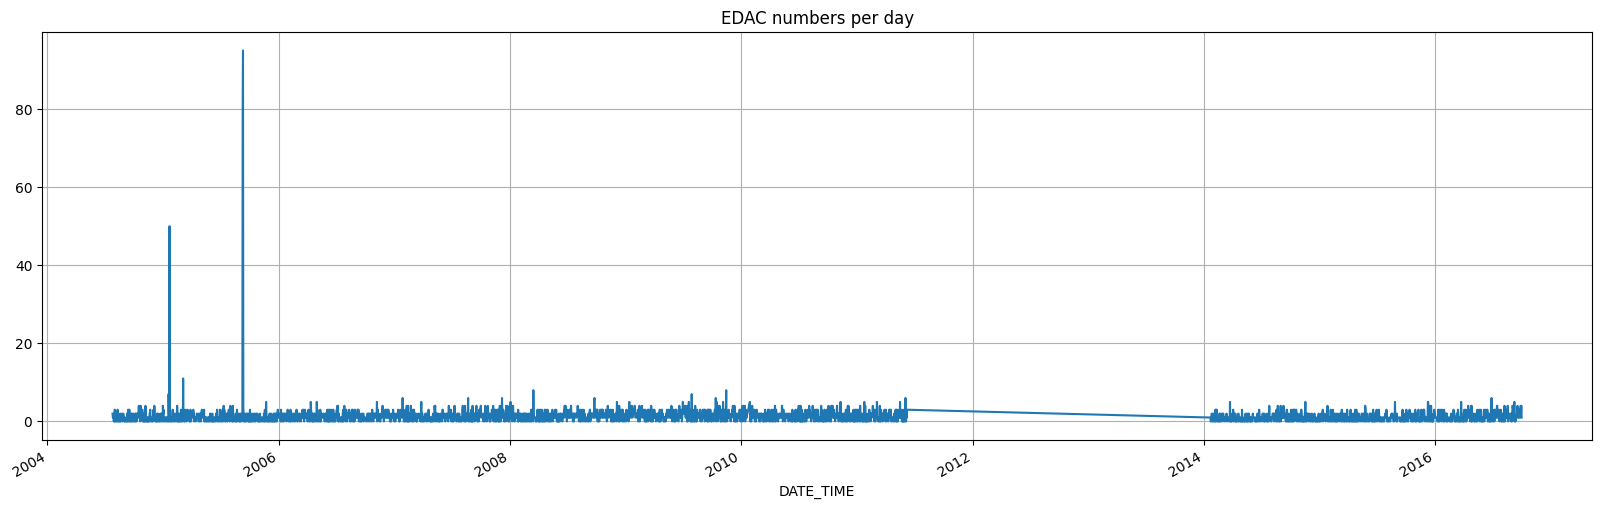

In [ ]:
# calcumate the counts per day and remove the resetting of the counter at 0
ros_df['EDAC'] = ros_df['EDAC_COUNTER'].diff() #.bfill().astype(int).map(lambda x: max(0, x))

ros_df['EDAC'].plot(kind='line', figsize=(20,6))
plt.title('EDAC numbers per day')
plt.grid()
plt.show()

In [ ]:
ros_cme_df = pd.read_csv(data_path+"MEX_CME_date_time.csv")

ros_df['cme'] = 0

for index, row in mex_cme_df.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']
    
    # Set 'cme' column values to 1 between start_time and end_time
    mex_df.loc[(mex_df.index >= start_time) & (mex_df.index <= end_time), 'cme'] = 1

mex_df['cme'].plot(kind='line', figsize=(20,6), color='red')
plt.title('CME events')
plt.grid()
plt.show()